In [1]:
%matplotlib inline

In [2]:
import os

import numpy as np

from astropy.convolution import Gaussian2DKernel
from astropy.io import fits
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u
from astropy.visualization import make_lupton_rgb, SqrtStretch, ImageNormalize, simple_norm
import astropy.wcs as wcs
from astropy.modeling import models
from astropy import units as u
from astropy.modeling.polynomial import Chebyshev1D

from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.fitting import continuum

from astropy import __version__ as astropy_version
print('astropy', astropy_version)

astropy 5.0.2


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

In [4]:
if not os.path.exists('./output'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/output.zip'
    boxfile = './output.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()
else:
    print('Already exists')

In [5]:
# Download files, if not exists yet.
if not os.path.exists('./pipeline_products'):
    import zipfile
    import urllib.request
    boxlink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/NIRISS_lensing_cluster/pipeline_products.zip'
    boxfile = './pipeline_products.zip'
    urllib.request.urlretrieve(boxlink, boxfile)
    zf = zipfile.ZipFile(boxfile, 'r')
    zf.extractall()

In [6]:
# Which target?
DIR_OUT = './output/'
filt = 'f200w'

grism = 'G150C'
#grism = 'G150R'

id = '00004'

In [7]:
# Open two-dimensional file;
# can be downloaded in No.01a.
DIR_DATA = './pipeline_products/'

# Zero-indexed number for dither --- the test data has two dither positions.
ndither = 0

# File
file_2d = '%sl3_nis_%s_%s_s%s_cal.fits'%(DIR_DATA, filt, grism, id)
hdu_2d = fits.open(file_2d)

# Align grism direction
#   - x-direction = Dispersion (wavelength) direction.
#   - y-direction = Cross-dispersion.
# in this notebook.
    
if grism == 'G150C':
    # If spectrum is horizontal;
    data_2d = hdu_2d[ndither*7+1].data
    dq_2d = hdu_2d[ndither*7+2].data
    err_2d = hdu_2d[ndither*7+3].data
    wave_2d = hdu_2d[ndither*7+4].data
else:
    data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
    dq_2d = rotate(hdu_2d[ndither*7+2].data, 90)
    err_2d = rotate(hdu_2d[ndither*7+3].data, 90)
    wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)

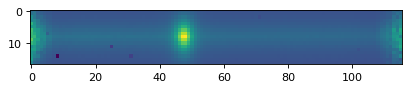

In [8]:
plt.imshow(data_2d[:,:])

(1.6, 2.3)

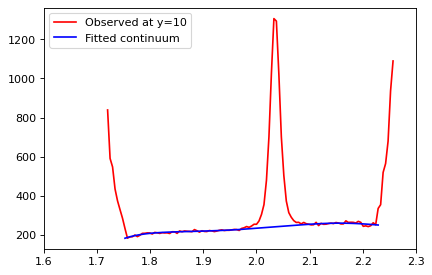

In [9]:
# At which y position do we want to see spectrum?
# as an example;
yy = 10

spec_unit = u.dimensionless_unscaled

mask_line = ((wave_2d[yy,:] > 1.75) & (wave_2d[yy,:] < 1.97)) | ((wave_2d[yy,:] > 2.08) & (wave_2d[yy,:] < 2.23))

obs  = Spectrum1D(spectral_axis=wave_2d[yy,:][mask_line]*u.um, flux=data_2d[yy,:][mask_line]*spec_unit)
cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

plt.plot(wave_2d[yy,:], data_2d[yy,:], color='r', label='Observed at y=%d'%(yy))
plt.plot(wave_2d[yy,:][mask_line]*u.um, cont(wave_2d[yy,:][mask_line]*u.um), color='b', label='Fitted continuum')

plt.legend(loc=0)
plt.xlim(1.6, 2.3)

In [10]:
cont(wave_2d[yy,:][mask_line]*u.um).value

array([250.33514625, 251.34196997, 252.3399539 , 253.31373358,
       254.24980241, 255.13666809, 255.96455649, 256.72516215,
       257.41178054, 258.01904392, 258.54273027, 258.97986573,
       259.32840475, 259.58730346, 259.75633833, 259.83601505,
       259.82753631, 259.73268276, 259.55376941, 259.29355234,
       258.95516032, 258.54210389, 258.05809227, 257.50714698,
       256.89339286, 256.22107226, 255.4946214 , 254.71842986,
       253.89689648, 253.03453451, 252.13569698, 251.2046636 ,
       227.2937026 , 226.56797698, 225.86951509, 225.19837698,
       224.55451447, 223.93770343, 223.34764344, 222.78388357,
       222.24585274, 221.73279607, 221.24384862, 220.7779845 ,
       220.33396715, 219.91041011, 219.50570908, 219.11804745,
       218.74533159, 218.38522917, 218.03510699, 217.69197741,
       217.35251716, 217.01299411, 216.66924474, 216.31659529,
       215.94986731, 215.56329808, 215.15045747, 214.70424554,
       214.21679044, 213.6794031 , 213.08244929, 212.41

In [11]:
# Repeat this along y-axis;
flux_cont2d = data_2d[:,:] * 0
for yy in range(len(data_2d[:,0])):

    mask_line = ((wave_2d[yy,:] > 1.75) & (wave_2d[yy,:] < 1.97)) | ((wave_2d[yy,:] > 2.08) & (wave_2d[yy,:] < 2.23))

    obs = Spectrum1D(spectral_axis=wave_2d[yy,:][mask_line]*u.um, flux=data_2d[yy,:][mask_line]*spec_unit)
    cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

    flux_cont2d[yy,:] = cont(wave_2d[yy,:]*u.um).value

Text(0.5, 1.0, 'Fitted continuum')

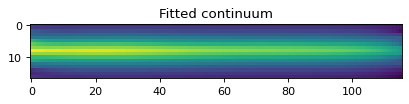

In [12]:
plt.imshow(flux_cont2d[:,:])
plt.title('Fitted continuum')

Text(0.5, 1.0, 'Continuum subtracted spectrum')

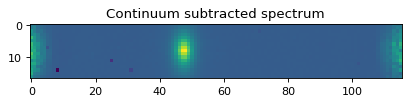

In [13]:
plt.imshow(data_2d[:,:] - flux_cont2d[:,:])
plt.title('Continuum subtracted spectrum')

Text(0.5, 1.0, 'H$\\alpha$ map')

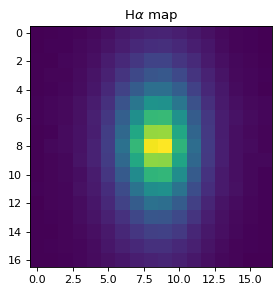

In [14]:
# Cutout Ha line map;
rsq = data_2d.shape[0]
cut_ha = np.zeros((rsq,rsq),'float32')

zin = 2.1 # From Notebook No.3, cross-correlation;
lamcen = 0.6564 * (1. + zin)

for yy in range(len(data_2d[:,0])):
    # This has to be done at each y pixel, as wavelength array can be tilted.
    index_lamcen = np.argmin(np.abs(lamcen - wave_2d[yy,:]))
    cut_ha[yy,:] = (data_2d - flux_cont2d)[yy, int(index_lamcen-rsq/2.) : int(index_lamcen+rsq/2.)]

plt.imshow(cut_ha)
plt.title('H$\\alpha$ map')

Text(0.5, 1.0, 'f150w')

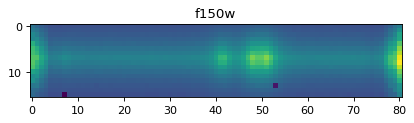

In [15]:
filt = 'f150w'

file_2d = '%sl3_nis_%s_%s_s%s_cal.fits'%(DIR_DATA, filt, grism, id)
hdu_2d = fits.open(file_2d)

# Align grism direction
#   - x-direction = Dispersion (wavelength) direction.
#   - y-direction = Cross-dispersion.
# in this notebook.
    
if grism == 'G150C':
    # If spectrum is horizontal;
    data_2d = hdu_2d[ndither*7+1].data
    dq_2d = hdu_2d[ndither*7+2].data
    err_2d = hdu_2d[ndither*7+3].data
    wave_2d = hdu_2d[ndither*7+4].data
else:
    data_2d = rotate(hdu_2d[ndither*7+1].data, 90)
    dq_2d = rotate(hdu_2d[ndither*7+2].data, 90)
    err_2d = rotate(hdu_2d[ndither*7+3].data, 90)
    wave_2d = rotate(hdu_2d[ndither*7+4].data, 90)
    
# !! Note that the extracted spectra has flipped wavelength direction !!
plt.imshow(data_2d[:, ::-1])
plt.title('%s'%(filt))


(1.2, 1.8)

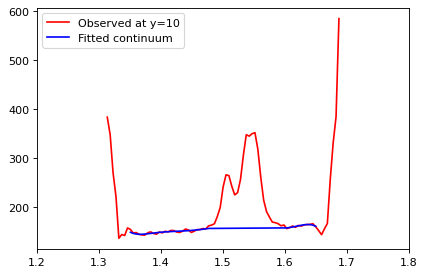

In [16]:
yy = 10 # as an example;

spec_unit = u.dimensionless_unscaled

mask_line = ((wave_2d[yy,:] > 1.35) & (wave_2d[yy,:] < 1.48)) | ((wave_2d[yy,:] > 1.6) & (wave_2d[yy,:] < 1.65))

obs = Spectrum1D(spectral_axis=wave_2d[yy,:][mask_line]*u.um, flux=data_2d[yy,:][mask_line]*spec_unit)
cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

plt.plot(wave_2d[yy,:], data_2d[yy,:], color='r', label='Observed at y=%d'%(yy))
plt.plot(wave_2d[yy,:][mask_line]*u.um, cont(wave_2d[yy,:][mask_line]*u.um), color='b', label='Fitted continuum')

plt.legend(loc=0)
plt.xlim(1.2, 1.8)

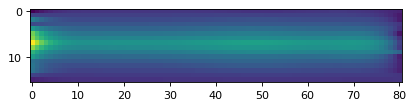

In [17]:
# Repeat this along y-axis;
flux_cont2d_150 = data_2d[:,:] * 0
for yy in range(len(data_2d[:,0])):

    mask_line = ((wave_2d[yy,:] > 1.35) & (wave_2d[yy,:] < 1.48)) | ((wave_2d[yy,:] > 1.6) & (wave_2d[yy,:] < 1.65))

    obs = Spectrum1D(spectral_axis=wave_2d[yy,:][mask_line]*u.um, flux=data_2d[yy,:][mask_line]*spec_unit)
    cont = continuum.fit_generic_continuum(obs, model=Chebyshev1D(7))

    flux_cont2d_150[yy,:] = cont(wave_2d[yy,:]*u.um).value

plt.imshow(flux_cont2d_150[:, ::-1])

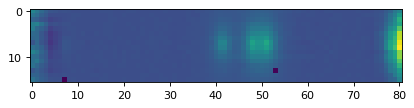

In [18]:
line_2d = data_2d[:,:] - flux_cont2d_150[:,:]

plt.imshow(line_2d[:, ::-1])

In [19]:
yy = 10

# Fit the spectrum
con = (1.4 < wave_2d[yy,:]) & (wave_2d[yy,:] < 1.65)

spectrum_cut = Spectrum1D(flux=line_2d[yy,:][con]*spec_unit,
                          spectral_axis=wave_2d[yy,:][con]*u.um)

# !!! Some tweaks may be needed for initial value, to successfuully run the fit;

# For Hb
g1_init = models.Gaussian1D(amplitude=40*spec_unit, mean=1.5*u.um, stddev=0.005*u.um)

# For O3 blue
g2_init = models.Gaussian1D(amplitude=50.*spec_unit, mean=1.535*u.um, stddev=0.002*u.um)

# For O3 red
g3_init = models.Gaussian1D(amplitude=45.*spec_unit, mean=1.55*u.um, stddev=0.001*u.um)

g123_fit = fit_lines(spectrum_cut, g1_init+g2_init+g3_init, window=[0.01*u.um,0.001*u.um,0.001*u.um])
y_fit = g123_fit(wave_2d[yy,:]*u.um)

print(g123_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1] + [2]
Components: 
    [0]: <Gaussian1D(amplitude=105.67672529 , mean=1.50774443 um, stddev=0.00935698 um)>

    [1]: <Gaussian1D(amplitude=82.09499951 , mean=1.53395958 um, stddev=0.0064488 um)>

    [2]: <Gaussian1D(amplitude=186.44732716 , mean=1.54938177 um, stddev=0.0110966 um)>
Parameters:
       amplitude_0           mean_0            stddev_0          amplitude_1          mean_1             stddev_1          amplitude_2          mean_2             stddev_2      
                               um                 um                                    um                  um                                    um                  um         
    ------------------ ----------------- -------------------- ----------------- ------------------ -------------------- ----------------- ------------------ --------------------
    105.67672528735608 1.507744432378453 0.009356977079030602 82.094999508331

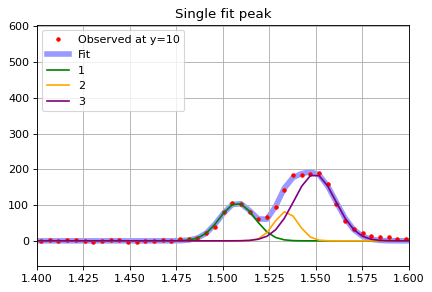

In [20]:
# Plot separately?
plt.plot(wave_2d[yy,:], line_2d[yy,:], marker='.', ls='', color='r', label='Observed at y=%d'%(yy))
plt.plot(wave_2d[yy,:], y_fit, color='b', label='Fit', zorder=-2, alpha=0.4, lw=5)

y_fit1 = g123_fit[0](wave_2d[yy,:]*u.um)
plt.plot(wave_2d[yy,:], y_fit1, color='g', label='1')

y_fit1 = g123_fit[1](wave_2d[yy,:]*u.um)
plt.plot(wave_2d[yy,:], y_fit1, color='orange', label='2')

y_fit1 = g123_fit[2](wave_2d[yy,:]*u.um)
plt.plot(wave_2d[yy,:], y_fit1, color='purple', label='3')

plt.xlim(1.4, 1.6)

plt.title('Single fit peak')
plt.grid(True)
plt.legend(loc=2)

In [21]:
print(g123_fit[0])
print(g123_fit[1])
print(g123_fit[2])

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             mean              stddev       
                               um                 um         
    ------------------ ----------------- --------------------
    105.67672528735608 1.507744432378453 0.009356977079030602
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
                              um                  um         
    ----------------- ------------------ --------------------
    82.09499950833157 1.5339595832025523 0.006448802572624894
Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean               stddev       
                              um                  um         
    ----------------- ------------------ --------------------
    186.4473271598496 1.5493817718595093 0.011096600264674869


In [22]:
# Cutout Hb, Oiii line maps;
rsq = data_2d.shape[0]
cut_hb  = np.zeros((rsq, rsq), 'float32')
cut_o3b = np.zeros((rsq, rsq), 'float32')
cut_o3r = np.zeros((rsq, rsq), 'float32')

zin = 2.1 # Redshift estimate from Notebook No.2, cross-correlation;
lamcen_hb  = 0.4862680 * (1. + zin)
lamcen_o3b = 0.4960295 * (1. + zin)
lamcen_o3r = 0.5008240 * (1. + zin)

for yy in range(len(data_2d[:,0])):
    # Fit the spectrum
    con = (1.4 < wave_2d[yy,:]) & (wave_2d[yy,:] < 1.65)
    spectrum_cut = Spectrum1D(flux=line_2d[yy,:][con]*spec_unit, 
                              spectral_axis=wave_2d[yy,:][con]*u.um)

    # !!! Some tweaks may be needed for initial value, to successfuully run the fit;

    # For Hb
    g1_init = models.Gaussian1D(amplitude=40*spec_unit, mean=1.5*u.um, stddev=0.005*u.um)
    # For O3 blue
    g2_init = models.Gaussian1D(amplitude=50.*spec_unit, mean=1.535*u.um, stddev=0.002*u.um)
    # For O3 red
    g3_init = models.Gaussian1D(amplitude=45.*spec_unit, mean=1.55*u.um, stddev=0.001*u.um)
    g123_fit = fit_lines(spectrum_cut, g1_init+g2_init+g3_init, window=[0.01*u.um, 0.001*u.um, 0.001*u.um])
    y_fit = g123_fit(wave_2d[yy,:]*u.um)

    # This has to be done at each y pixel, as wavelength array can be tilted.
    index_lamcen_hb = np.argmin(np.abs(lamcen_hb - wave_2d[yy,:]))
    cut_hb[yy,:] = g123_fit[0](wave_2d[yy,:]*u.um)[int(index_lamcen_hb-rsq/2.) : int(index_lamcen_hb+rsq/2.)]

    index_lamcen_o3b = np.argmin(np.abs(lamcen_o3b - wave_2d[yy,:]))
    cut_o3b[yy,:] = g123_fit[1](wave_2d[yy,:]*u.um)[int(index_lamcen_o3b-rsq/2.) : int(index_lamcen_o3b+rsq/2.)]

    index_lamcen_o3r = np.argmin(np.abs(lamcen_o3r - wave_2d[yy,:]))
    cut_o3r[yy,:] = g123_fit[2](wave_2d[yy,:]*u.um)[int(index_lamcen_o3r-rsq/2.) : int(index_lamcen_o3r+rsq/2.)]
    

Text(0.5, 1.0, 'H$\\beta$ map')

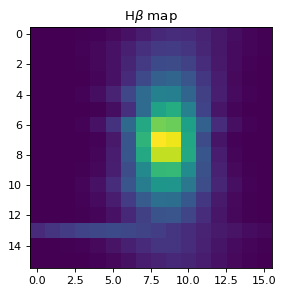

In [23]:
plt.imshow(cut_hb)
plt.title('H$\\beta$ map')

Text(0.5, 1.0, 'Oiii 4960')

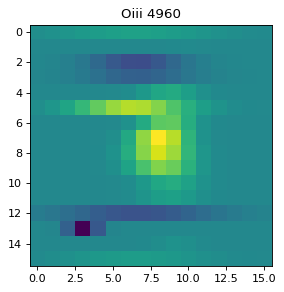

In [24]:
plt.imshow(cut_o3b)
plt.title('Oiii 4960')

Text(0.5, 1.0, 'Oiii 5008')

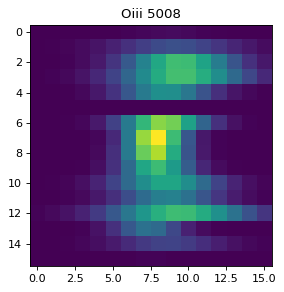

In [25]:
plt.imshow(cut_o3r)
plt.title('Oiii 5008')